### Binning

**Linear models** can only model linear relationships, which are lines in the case of a single feature. The decision tree can build a much more complex model of the data. However, this is strongly dependent on the representation of the data.
One way to make linear models more powerful on continuous data is to use **binning (also known as discretization) of the feature to split it up into multiple features**

In [6]:
import mglearn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

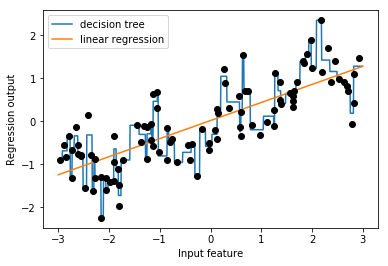

In [7]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

X, y = mglearn.datasets.make_wave(n_samples=100)
line = np.linspace(-3, 3, 1000, endpoint=False).reshape(-1, 1)

reg = DecisionTreeRegressor(min_samples_split=3).fit(X, y)
plt.plot(line, reg.predict(line), label="decision tree")

reg = LinearRegression().fit(X, y)
plt.plot(line, reg.predict(line), label="linear regression")

plt.plot(X[:, 0], y, 'o', c='k')
plt.ylabel("Regression output")
plt.xlabel("Input feature")
plt.legend(loc="best")

In [8]:
X.shape

(100, 1)

- We imagine a partition of the input range for the feature (in this case, the numbers from –3 to 3) into a fixed number of bins—say, 10. 
- A data point will then be represented by which bin it falls into. To determine this, we first have to define the bins. 
- In this case, we’ll define 10 bins equally spaced between –3 and 3. We use the np.linspace function for this, creating 11 entries, which will create 10 bins—they are the spaces in between two consecutive boundaries

In [9]:
bins = np.linspace(-3, 3, 11)
print("bins: {}".format(bins))

bins: [-3.  -2.4 -1.8 -1.2 -0.6  0.   0.6  1.2  1.8  2.4  3. ]


- Now, we record for each data point which bin it falls into 
- This can be easily computed using the *np.digitize* function

In [10]:
which_bin = np.digitize(X, bins=bins)
print("\nData points:\n", X[:5])
print("\nBin membership for data points:\n", which_bin[:5])


Data points:
 [[-0.75275929]
 [ 2.70428584]
 [ 1.39196365]
 [ 0.59195091]
 [-2.06388816]]

Bin membership for data points:
 [[ 4]
 [10]
 [ 8]
 [ 6]
 [ 2]]


What we did here is **transform the single continuous input feature in the wave dataset into a categorical feature that encodes which bin a data point is in**.

- To use a scikit-learn model on this data, we transform this discrete feature to a one-hot encoding using the OneHotEncoder from the preprocessing module. 
- The OneHotEncoder does the same encoding as pandas.get_dummies, though it currently only works on categorical variables that are integers

In [11]:
from sklearn.preprocessing import OneHotEncoder
# transform using the OneHotEncoder
encoder = OneHotEncoder(sparse=False)
# encoder.fit finds the unique values that appear in which_bin
encoder.fit(which_bin)
# transform creates the one-hot encoding
X_binned = encoder.transform(which_bin)
print(X_binned[:5])

[[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]


Because we specified 10 bins, the transformed dataset X_binned now is made up of 10 features:

In [12]:
print("X_binned.shape: {}".format(X_binned.shape))

X_binned.shape: (100, 10)


Now we build a new linear regression model and a new decision tree model on the one-hot-encoded data. 

Text(0.5,0,'Input feature')

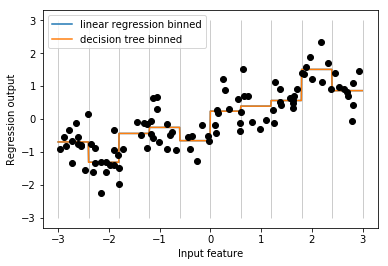

In [13]:
line_binned = encoder.transform(np.digitize(line, bins=bins))

reg = LinearRegression().fit(X_binned, y)
plt.plot(line, reg.predict(line_binned), label='linear regression binned')

reg = DecisionTreeRegressor(min_samples_split=3).fit(X_binned, y)
plt.plot(line, reg.predict(line_binned), label='decision tree binned')
plt.plot(X[:, 0], y, 'o', c='k')
plt.vlines(bins, -3, 3, linewidth=1, alpha=.2)
plt.legend(loc="best")
plt.ylabel("Regression output")
plt.xlabel("Input feature")

- The dashed line and solid line are exactly on top of each other, meaning the linear regression model and the decision tree make exactly the same predictions. For each bin, they predict a constant value.
- As features are constant within each bin, any model must predict the same value for all points within a bin.
- Comparing what the models learned before binning the features and after, we see that the linear model became much more flexible, because it now has a different value for each bin, while the decision tree model got much less flexible.
- Binning features generally has no beneficial effect for tree-based models, as these models can learn to split up the data anywhere.
- If there are good reasons to use a linear model for a particular dataset—say, because it is very large and high dimensional, but some features have nonlinear relations with the output—binning can be a great way to increase modeling power.

#### Interactions

- Previously, the linear model learned a constant value for each bin in the wave dataset.
- But linear models can learn not only offsets but slopes as well
- One way to add a slope to the linear model on the binned data is to add the original feature (the x-axis in the plot) back in. This leads to an 11-dimensional dataset

In [14]:
X_combined = np.hstack([X, X_binned])
print(X_combined.shape)

(100, 11)


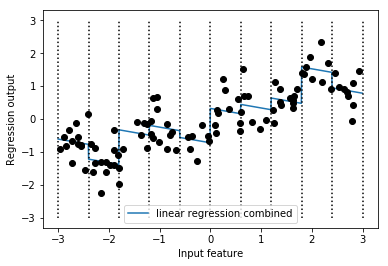

In [17]:
reg = LinearRegression().fit(X_combined, y)

line_combined = np.hstack([line, line_binned])
plt.plot(line, reg.predict(line_combined), label='linear regression combined')

for bin in bins:
    plt.plot([bin, bin], [-3, 3], ':', c='k')

plt.legend(loc="best")
plt.ylabel("Regression output")
plt.xlabel("Input feature")
plt.plot(X[:, 0], y, 'o', c='k')

- Here, the model learned an offset for each bin, together with a slope. 
- The learned slope is downward, and shared across all the bins—there is a single x-axis feature, which has a single slope.
- Because the slope is shared across all bins, it doesn’t seem to be very helpful. We would rather have a separate slope for each bin.
- We can achieve this by **adding an interaction or product feature** that indicates which bin a data point is in and where it lies on the x-axis. 
- This feature is a product of the bin indicator and the original feature

In [18]:
X_product = np.hstack([X_binned, X * X_binned])
print(X_product.shape)

(100, 20)


The dataset now has 20 features: the indicators for which bin a data point is in, and a product of the original feature and the bin indicator. The product feature is a separate copy of the x-axis feature for each bin. It is the original feature within the bin, and zero everywhere else.

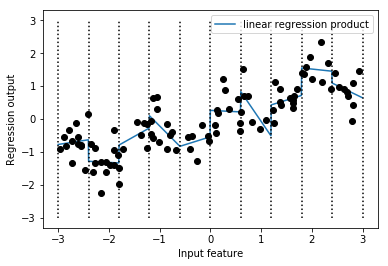

In [19]:
reg = LinearRegression().fit(X_product, y)

line_product = np.hstack([line_binned, line * line_binned])
plt.plot(line, reg.predict(line_product), label='linear regression product')

for bin in bins:
    plt.plot([bin, bin], [-3, 3], ':', c='k')

plt.plot(X[:, 0], y, 'o', c='k')
plt.ylabel("Regression output")
plt.xlabel("Input feature")
plt.legend(loc="best")

Now each bin has its own offset and slope in this model

### Using Polynomials of the original features

Using binning is one way to expand a continuous feature. Another one is to use **polynomials** of the original features. For a given feature x, we might want to consider **x ** 2, x ** 3, x ** 4**, and so on. This is implemented in *PolynomialFeatures* in the preprocessing module

In [20]:
from sklearn.preprocessing import PolynomialFeatures

# include polynomials up to x ** 10:
# the default "include_bias=True" adds a feature that's constantly 1
poly = PolynomialFeatures(degree=10, include_bias=False)
poly.fit(X)
X_poly = poly.transform(X)

In [21]:
#Using a degree of 10 yields 10 features:
print("X_poly.shape: {}".format(X_poly.shape))

X_poly.shape: (100, 10)


In [25]:
print("Entries of X:\n{}".format(X[:5]))
print("Entries of X_poly:\n{}".format(X_poly[:5]))

Entries of X:
[[-0.75275929]
 [ 2.70428584]
 [ 1.39196365]
 [ 0.59195091]
 [-2.06388816]]
Entries of X_poly:
[[-7.52759287e-01  5.66646544e-01 -4.26548448e-01  3.21088306e-01
  -2.41702204e-01  1.81943579e-01 -1.36959719e-01  1.03097700e-01
  -7.76077513e-02  5.84199555e-02]
 [ 2.70428584e+00  7.31316190e+00  1.97768801e+01  5.34823369e+01
   1.44631526e+02  3.91124988e+02  1.05771377e+03  2.86036036e+03
   7.73523202e+03  2.09182784e+04]
 [ 1.39196365e+00  1.93756281e+00  2.69701700e+00  3.75414962e+00
   5.22563982e+00  7.27390068e+00  1.01250053e+01  1.40936394e+01
   1.96178338e+01  2.73073115e+01]
 [ 5.91950905e-01  3.50405874e-01  2.07423074e-01  1.22784277e-01
   7.26822637e-02  4.30243318e-02  2.54682921e-02  1.50759786e-02
   8.92423917e-03  5.28271146e-03]
 [-2.06388816e+00  4.25963433e+00 -8.79140884e+00  1.81444846e+01
  -3.74481869e+01  7.72888694e+01 -1.59515582e+02  3.29222321e+02
  -6.79478050e+02  1.40236670e+03]]


We can obtain the semantics of the features by calling the **get_feature_names** method, which provides the exponent for each feature

In [27]:
print("Polynomial feature names:\n{}".format(poly.get_feature_names()))

Polynomial feature names:
['x0', 'x0^2', 'x0^3', 'x0^4', 'x0^5', 'x0^6', 'x0^7', 'x0^8', 'x0^9', 'x0^10']


You can see that the first column of X_poly corresponds exactly to X, while the other columns are the powers of the first entry. **Using polynomial features together with a linear regression model yields the classical model of polynomial regression.**

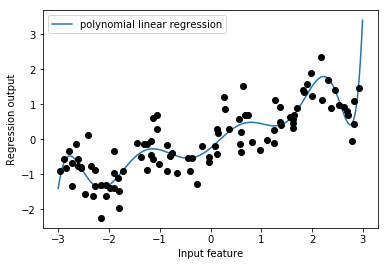

In [28]:
reg = LinearRegression().fit(X_poly, y)
line_poly = poly.transform(line)
plt.plot(line, reg.predict(line_poly), label='polynomial linear regression')
plt.plot(X[:, 0], y, 'o', c='k')
plt.ylabel("Regression output")
plt.xlabel("Input feature")

plt.legend(loc="best")

Applying on the **Boston Housing dataset**

In [34]:
# First we load the data, and rescale it to be between 0 and 1 using MinMaxScaler

from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

boston = load_boston()
X_train, X_test, y_train, y_test = train_test_split(boston.data, boston.target, random_state=0)

# rescale data
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# Now, we extract polynomial features and interactions up to a degree of 2
poly = PolynomialFeatures(degree=2).fit(X_train_scaled)
X_train_poly = poly.transform(X_train_scaled)
X_test_poly = poly.transform(X_test_scaled)
print("X_train.shape: {}".format(X_train.shape))
print("X_train_poly.shape: {}".format(X_train_poly.shape))

X_train.shape: (379, 13)
X_train_poly.shape: (379, 105)


- The data originally had 13 features, which were expanded into 105 interaction features. 
- These new features represent all possible interactions between two different original features, as well as the square of each original feature. 
- degree=2 here means that we look at all features that are the product of up to two original features. 
- The exact correspondence between input and output features can be found using the get_feature_names method

In [36]:
print("Polynomial feature names:\n{}".format(poly.get_feature_names()))

Polynomial feature names:
['1', 'x0', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10', 'x11', 'x12', 'x0^2', 'x0 x1', 'x0 x2', 'x0 x3', 'x0 x4', 'x0 x5', 'x0 x6', 'x0 x7', 'x0 x8', 'x0 x9', 'x0 x10', 'x0 x11', 'x0 x12', 'x1^2', 'x1 x2', 'x1 x3', 'x1 x4', 'x1 x5', 'x1 x6', 'x1 x7', 'x1 x8', 'x1 x9', 'x1 x10', 'x1 x11', 'x1 x12', 'x2^2', 'x2 x3', 'x2 x4', 'x2 x5', 'x2 x6', 'x2 x7', 'x2 x8', 'x2 x9', 'x2 x10', 'x2 x11', 'x2 x12', 'x3^2', 'x3 x4', 'x3 x5', 'x3 x6', 'x3 x7', 'x3 x8', 'x3 x9', 'x3 x10', 'x3 x11', 'x3 x12', 'x4^2', 'x4 x5', 'x4 x6', 'x4 x7', 'x4 x8', 'x4 x9', 'x4 x10', 'x4 x11', 'x4 x12', 'x5^2', 'x5 x6', 'x5 x7', 'x5 x8', 'x5 x9', 'x5 x10', 'x5 x11', 'x5 x12', 'x6^2', 'x6 x7', 'x6 x8', 'x6 x9', 'x6 x10', 'x6 x11', 'x6 x12', 'x7^2', 'x7 x8', 'x7 x9', 'x7 x10', 'x7 x11', 'x7 x12', 'x8^2', 'x8 x9', 'x8 x10', 'x8 x11', 'x8 x12', 'x9^2', 'x9 x10', 'x9 x11', 'x9 x12', 'x10^2', 'x10 x11', 'x10 x12', 'x11^2', 'x11 x12', 'x12^2']


The first new feature is a constant feature, called "1" here. The next 13 features are the original features (called "x0" to "x12"). Then follows the first feature squared ("x0^2") and combinations of the first and the other features.

In [37]:
from sklearn.linear_model import Ridge
ridge = Ridge().fit(X_train_scaled, y_train)
print("Score without interactions: {:.3f}".format(
    ridge.score(X_test_scaled, y_test)))
ridge = Ridge().fit(X_train_poly, y_train)
print("Score with interactions: {:.3f}".format(
    ridge.score(X_test_poly, y_test)))

Score without interactions: 0.621
Score with interactions: 0.753


When using a more complex model like a random forest, the story is a bit different

In [38]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=100).fit(X_train_scaled, y_train)
print("Score without interactions: {:.3f}".format(
    rf.score(X_test_scaled, y_test)))
rf = RandomForestRegressor(n_estimators=100).fit(X_train_poly, y_train)
print("Score with interactions: {:.3f}".format(rf.score(X_test_poly, y_test)))

Score without interactions: 0.802
Score with interactions: 0.784


### Univariate Nonlinear Transformations

- We just saw that adding squared or cubed features can help linear models for regression. There are other transformations that often prove useful for transforming certain features: in particular, applying mathematical functions like log, exp, or sin. 
- While tree-based models only care about the ordering of the features, linear models and neural networks are very tied to the scale and distribution of each feature, and if there is a nonlinear relation between the feature and the target, that becomes hard to model particularly in regression. 
- The functions log and exp can help by adjusting the relative scales in the data so that they can be captured better by a linear model or neural network.

- A particularly common case when such a transformation can be helpful is when dealing with integer count data.
- By count data, we mean features like “how often did user A log in?” 
- Counts are never negative, and often follow particular statistical patterns. 
- We are using a synthetic dataset of counts here that has properties similar to those you can find in the wild.

In [41]:
rnd = np.random.RandomState(0)
X_org = rnd.normal(size=(1000, 3))
w = rnd.normal(size=3)

X = rnd.poisson(10 * np.exp(X_org))
y = np.dot(X_org, w)

print("Number of feature appearances:\n{}".format(np.bincount(X[:, 0])))

Number of feature appearances:
[28 38 68 48 61 59 45 56 37 40 35 34 36 26 23 26 27 21 23 23 18 21 10  9
 17  9  7 14 12  7  3  8  4  5  5  3  4  2  4  1  1  3  2  5  3  8  2  5
  2  1  2  3  3  2  2  3  3  0  1  2  1  0  0  3  1  0  0  0  1  3  0  1
  0  2  0  1  1  0  0  0  0  1  0  0  2  2  0  1  1  0  0  0  0  1  1  0
  0  0  0  0  0  0  1  0  0  0  0  0  1  1  0  0  1  0  0  0  0  0  0  0
  1  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1]


In [42]:
from sklearn.linear_model import Ridge
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
score = Ridge().fit(X_train, y_train).score(X_test, y_test)
print("Test score: {:.3f}".format(score))

Test score: 0.622


As you can see from the relatively low R2 score, Ridge was not able to really capture the relationship between X and y. Applying a logarithmic transformation can help, though. Because the value 0 appears in the data (and the logarithm is not defined at 0), we can’t actually just apply log, but we have to compute log(X + 1)

In [43]:
X_train_log = np.log(X_train + 1)
X_test_log = np.log(X_test + 1)

Text(0.5,0,'Value')

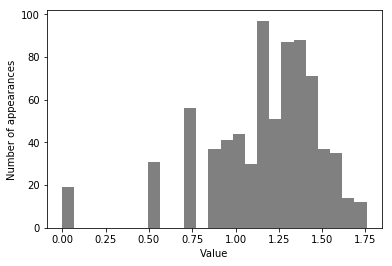

In [44]:
plt.hist(np.log(X_train_log[:, 0] + 1), bins=25, color='gray')
plt.ylabel("Number of appearances")
plt.xlabel("Value")

In [45]:
score = Ridge().fit(X_train_log, y_train).score(X_test_log, y_test)
print("Test score: {:.3f}".format(score))

Test score: 0.875


- Finding the transformation that works best for each combination of dataset and model is somewhat of an art. In this example, all the features had the same properties.
- This is rarely the case in practice, and usually only a subset of the features should be transformed, or sometimes each feature needs to be transformed in a different way.
- As we mentioned earlier, these kinds of transformations are irrelevant for tree-based models but might be essential for linear models. 